# Using LSTM to predict NVDA prices

Using LSTM:
- Maintains an internal state, allowing it to have memory of previous inputs

1.	Handling Sequential Data: LSTM (Long Short-Term Memory) networks are specifically designed to handle and predict sequences of data, making them well-suited for time series forecasting like stock prices.
2.	Capturing Long-Term Dependencies: LSTM networks can remember information for long periods, thanks to their ability to maintain a memory cell that updates and forgets information over time. This is crucial for stock price prediction, where historical data can influence future values.

In [12]:
# importing libraries

import pandas as pd # data visualization
import numpy as np # number manipulation
from sklearn.preprocessing import MinMaxScaler # helps to normalize data
from keras.models import Sequential # allows you to build a NN in a sequential stack
from keras.layers import LSTM, Dense # to define the neural network being used + hidden layers

# note that need to pip install tensorflow - keras is built on tensorflow

In [29]:
# load data

data = pd.read_csv('./NVDA.csv')
print(data.head())  # Check the first few rows of the data
data = data[['Date', 'Close']] # keeps only the date and close columns
print(data.head()) # Check the first few rows of the data
data['Date'] = pd.to_datetime(data['Date']) # converts the date column to datetime
data.set_index('Date', inplace=True) # sets the date column as the index

# pre-process data

scaler = MinMaxScaler(feature_range=(0, 1)) # defines the scaler object used to normalise the data
scaled_data = scaler.fit_transform(data) # normalises data using MinMaxScaler -> reminder that range of data fed into a RNN should ideally be 0 to 1

sequence_length = 60 # define input size
X, y = [], [] # X = input data, y = labels
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0]) # X contains groups of 60 data points
    y.append(scaled_data[i, 0]) # y contains the data point right at the end of the 60 points in X 
X, y = np.array(X), np.array(y) # puts X and y into numpy arrays so that they can be reshaped to be fed into the RNN
X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # X.shape -> (number_of_samples, sequence_length) This reshapes X to the format needed for an input for keras

print(X)
print(y)

split = int(len(X) * 0.8) # 80% train, 20% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

         Date       Open       High        Low      Close  Adj Close  \
0  2023-06-20  42.998001  43.990002  42.674000  43.807999  43.794888   
1  2023-06-21  43.500999  43.615002  42.080002  43.044998  43.032112   
2  2023-06-22  42.252998  43.425999  42.234001  43.025002  43.012127   
3  2023-06-23  42.464001  42.808998  42.014999  42.209000  42.196365   
4  2023-06-26  42.460999  42.764000  40.099998  40.632000  40.619839   

      Volume  
0  451153000  
1  551603000  
2  417737000  
3  358140000  
4  594322000  
         Date      Close
0  2023-06-20  43.807999
1  2023-06-21  43.044998
2  2023-06-22  43.025002
3  2023-06-23  42.209000
4  2023-06-26  40.632000
[[[0.03655488]
  [0.02854471]
  [0.02833479]
  ...
  [0.0509375 ]
  [0.04770402]
  [0.05416046]]

 [[0.02854471]
  [0.02833479]
  [0.0197682 ]
  ...
  [0.04770402]
  [0.05416046]
  [0.0551683 ]]

 [[0.02833479]
  [0.0197682 ]
  [0.00321246]
  ...
  [0.05416046]
  [0.0551683 ]
  [0.03752075]]

 ...

 [[0.52539527]
  [0.5365548

In [56]:
# TODO: Understand shape of data for inputs and outputs for each layer

# Shape: (number_of_samples, sequence_length, no. of features)

# Build LSTM model
model = Sequential()
# input: (batch_size, 60, 1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # X_train.shape[1] = 60, the second value in the tuple is the number of features which in this case is 1, the closing price
# return_sequence=True: first LSTM layer passes all hidden states to the next LSTM layer eg
# [ [h1_t1, h1_t2, h1_t3, ..., h1_t60], 
#  [h2_t1, h2_t2, h2_t3, ..., h2_t60], 
#  ... ] ]
# output: (batch_size, 60, 50)

# note that each neuron takes a set of 60 data points, each neuron has a diff weight

# input: (batch_size, 60, 50)
model.add(LSTM(units=50, return_sequences=False)) 
# return_sequence=False: 2nd LSTM layer only returns the FINAL hidden state to the next two layers
# [ h1_t60, 
#  h2_t60, 
#  ... ] 

# output: (batch_size, 50)

# The two LSTM layers help to capture the temporal dependencies in the data

# input: (batch_size, 50)

model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
153/153 [==============================] - 3s 11ms/step - loss: 0.0055
Epoch 2/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0017
Epoch 3/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0017
Epoch 4/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0013
Epoch 5/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0016
Epoch 6/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0016
Epoch 7/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0013
Epoch 8/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0013
Epoch 9/10
153/153 [==============================] - 2s 11ms/step - loss: 0.0013
Epoch 10/10
153/153 [==============================] - 2s 11ms/step - loss: 9.6137e-04


In [57]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 0s 6ms/step


In [58]:
# Evaluate model
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'RMSE: {rmse}')

RMSE: 97.98670200212213


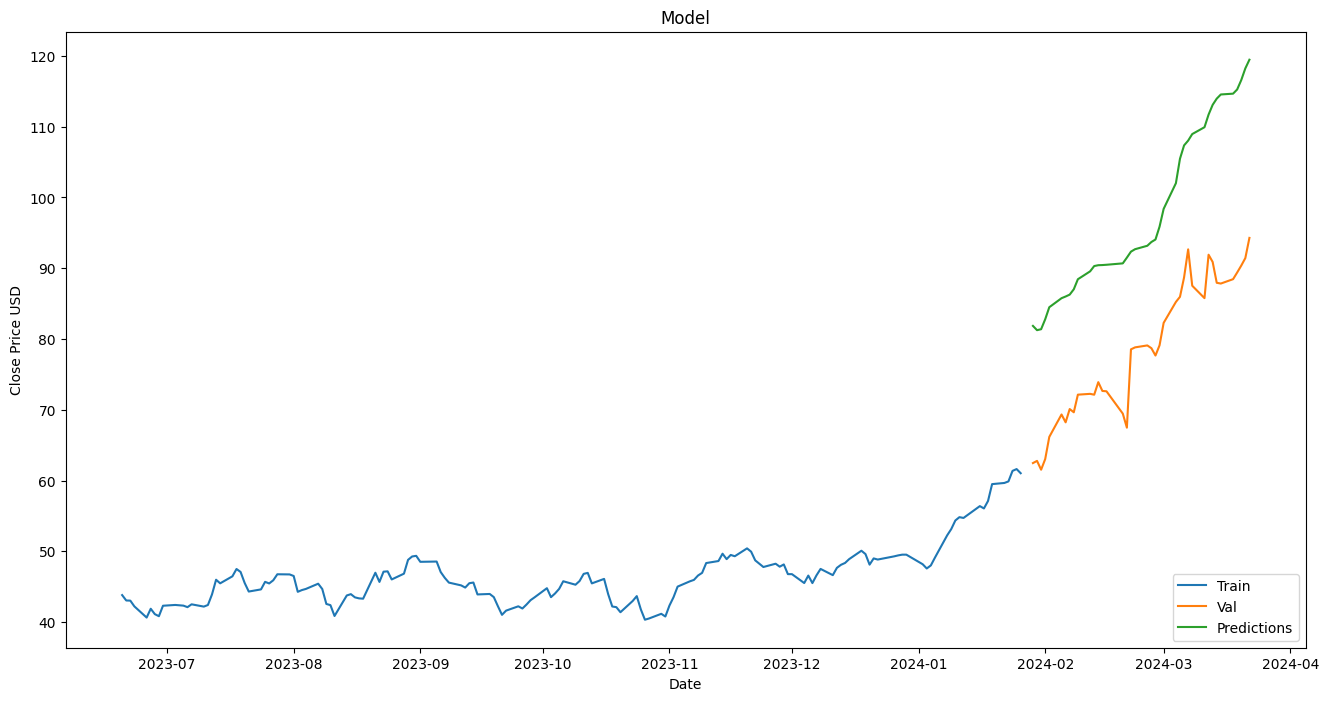

In [59]:
# Visualize predictions
import matplotlib.pyplot as plt

# Assuming data is the original DataFrame with Date and Close columns
train = data[:split]
valid = data[split:]

# Ensure predictions have the same length as valid
valid = valid.iloc[:len(predictions)].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
plt.show()